<a href="https://colab.research.google.com/github/Hyperstrom/Age_Gender_Prediction/blob/main/Age_and_Gender_Prediction_using_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎉 **Importing Packages with Flair!** 🎉

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
from typing import List
from matplotlib import pyplot as plt
import imageio

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed,SeparableConv2D
from tensorflow.keras.models import Sequential
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

import keras
from keras.layers import *
from keras.models import Model

from keras.applications.vgg16 import preprocess_input, VGG16
from keras.regularizers import l2

from tensorflow.keras.preprocessing.image import load_img
import numpy as np
from tqdm import tqdm

from keras.layers import Input, concatenate
from keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input

In [ ]:
import tensorflow as tf

set the device to the GPU for better performance

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

Give 3 GB of GPU for the traing process

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only allocate 3GB of GPU memory
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3200)]
        )
    except RuntimeError as e:
        print(e)

# **Image Data Preparation**📸
---
In this section, we will take the image data from the folder. We will be using the UTKFace dataset, which is available on Kaggle.

Dataset Link: [UTKFace Dataset on Kaggle](https://www.kaggle.com/datasets/jangedoo/utkface-new)



In [ ]:
folder_path = 'OneDrive\\Desktop\\age and gender practiction\\utkcropped'

In [ ]:
age =[]
gender =[]
image_path =[]
for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  image_path.append(file)

In [ ]:
len(age)

23709

In [ ]:
df = pd.DataFrame({'age':age,'gender':gender,'image':image_path})

In [ ]:
# male - 0 female -1

In [ ]:
df.head()

age  gender                                   image
0  100       0  100_0_0_20170112213500903.jpg.chip.jpg
1  100       0  100_0_0_20170112215240346.jpg.chip.jpg
2  100       1  100_1_0_20170110183726390.jpg.chip.jpg
3  100       1  100_1_0_20170112213001988.jpg.chip.jpg
4  100       1  100_1_0_20170112213303693.jpg.chip.jpg

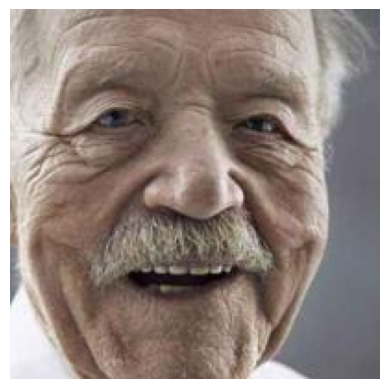

In [ ]:
# Select an image from the DataFrame
selected_image_index = 0  # You can change this index to view other images
selected_image_path = os.path.join(folder_path, df['image'][selected_image_index])

# Read the image with OpenCV
image = cv2.imread(selected_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the RGB image
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


In [ ]:
df.shape

(23709, 3)

# **Split the Data into Train and Test**
---

📂 We will split the data into training and testing/validation sets.

- 🏋️ **Training Set**: 20,000 images
- 🧪 **Testing/Validation Set**: The remaining 3,709 images


In [ ]:
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1,random_state=0).iloc[20000:]

In [ ]:
train_df.shape

(20000, 3)

In [ ]:
test_df.shape

(3709, 3)

# **Data Augmentation for Train and Test Data** 🌟

Data augmentation is a technique used to increase the diversity of your training data without actually collecting new data. By applying random transformations such as rotations, flips, and zooms to the existing images, we can help the model generalize better to new, unseen data. This is crucial for improving the robustness and performance of our model.

## Why We Do Data Augmentation

- **Improves Model Generalization**: Augmentation helps the model to generalize better by making it see variations of the same data.
- **Prevents Overfitting**: By increasing the diversity of training data, it reduces the risk of the model overfitting to the training set.
- **Enhances Model Robustness**: It makes the model more robust to variations and distortions in real-world data.

Let's apply data augmentation techniques to both our training and testing/validation datasets to ensure our model performs well in different scenarios.

In [ ]:
#data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=folder_path,
                                                    x_col='image',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                    batch_size=32,
                                                    class_mode='multi_output')

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                    directory=folder_path,
                                                    x_col='image',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                    batch_size = 32,
                                                    class_mode='multi_output')

Found 20000 validated image filenames.
Found 3709 validated image filenames.


Check the Image Dimensions with Batch Size of Training Data and Testing data 🖼️🔍

In this section, we will check the image dimensions alongside the batch size of the training data to ensure consistency and correctness.


In [ ]:
print("Training Data:")
for batch in train_generator:
    images, labels = batch
    print("Images shape:", images.shape)
    print("Age labels shape:", labels[0].shape)
    print("Gender labels shape:", labels[1].shape)
    break


Training Data:
Images shape: (32, 200, 200, 3)
Age labels shape: (32,)
Gender labels shape: (32,)


In [ ]:
# prompt: make the train_generator , test_generator age and gender output (none, 1,1)

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=folder_path,
                                                    x_col='image',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                    batch_size=32,
                                                    class_mode='multi_output')

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                    directory=folder_path,
                                                    x_col='image',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                    batch_size = 32,
                                                    class_mode='multi_output')

# Reshape the age and gender labels to have a single dimension
train_generator.labels[0] = np.expand_dims(train_generator.labels[0], axis=1)
train_generator.labels[1] = np.expand_dims(train_generator.labels[1], axis=1)

test_generator.labels[0] = np.expand_dims(test_generator.labels[0], axis=1)
test_generator.labels[1] = np.expand_dims(test_generator.labels[1], axis=1)

print("Training Data:")
for batch in train_generator:
    images, labels = batch
    print("Images shape:", images.shape)
    print("Age labels shape:", labels[0].shape)
    print("Gender labels shape:", labels[1].shape)
    break


Found 20000 validated image filenames.
Found 3709 validated image filenames.
Training Data:
Images shape: (32, 200, 200, 3)
Age labels shape: (32, 1)
Gender labels shape: (32, 1)


# **Import VGG16 from Keras Models** 📚
---
The VGG16 model is a pre-trained convolutional neural network (CNN) that has been widely used for image classification tasks. It was trained on the ImageNet dataset, which contains millions of images across thousands of classes. VGG16 is known for its deep architecture and uniform design of convolutional layers, making it highly effective for feature extraction.






We use transfer learning for better results by leveraging the VGG16 model as a convolution base. In this approach, we freeze the last convolution layer of VGG16 to retain the learned features while allowing the rest of the model to be fine-tuned for our specific task.

In [ ]:
vgg = VGG16(
    include_top = False,
    input_shape=(200,200,3)
)

In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [ ]:
from tensorflow.keras import layers

# **Model Architecture** 🏗️
---

In this section, we will define the architecture of our model. We will utilize the VGG16 model as our convolutional base and add additional layers on top for our specific task.


In [ ]:
inputs = Input(shape=(200, 200, 3))

# Define the convolutional base
cnn1 = SeparableConv2D(64, (3,3) , activation='relu', padding='same', name='block1_conv1')(inputs)
max1 = MaxPool2D(pool_size=(2,2))(cnn1)


cnn2 = SeparableConv2D(128, (3,3) , activation='relu', padding='same', name='block2_conv1')(max1)
max2 = MaxPool2D(pool_size=(2,2))(cnn2)

cnn3 = SeparableConv2D(128, (3,3) , activation='relu', padding='same', name='block3_conv1')(max2)
max3 = MaxPool2D(pool_size=(2,2))(cnn3)

cnn4 = SeparableConv2D(256, (3,3) , activation='relu', padding='same', name='block4_conv1')(max3)
max4 = MaxPool2D(pool_size=(2,2))(cnn4)

cnn5 = SeparableConv2D(256, (3,3) , activation='relu', padding='same', name='block5_conv1')(max4)
max5 = MaxPool2D(pool_size=(2,2))(cnn5)

flatten = TimeDistributed(Flatten())(max5)
# x = Reshape((1, -1))(flatten)

dense_1 = Bidirectional(GRU(256,kernel_initializer='Orthogonal', return_sequences=True))(flatten)
dense_2 = Bidirectional(GRU(256,kernel_initializer='Orthogonal', return_sequences=True))(flatten)

dropout_1 = Dropout(0.15) (dense_1)
dropout_2 = Dropout(0.15) (dense_2)

dense_3 = Bidirectional(GRU(256,kernel_initializer='Orthogonal', return_sequences=True))(dropout_1)
dense_4 = Bidirectional(GRU(256,kernel_initializer='Orthogonal', return_sequences=True))(dropout_2)

dropout_3 = BatchNormalization() (dense_3)
dropout_4 = BatchNormalization() (dense_4)

output_1 = Dense(1, activation ='relu', name = 'age')(dropout_3)
output_2 = Dense(1, activation ='softmax', name = 'gender')(dropout_4)

In [ ]:
vgg.trainable = False

output = vgg.layers[-1].output

flatten = Flatten()(output)

x = layers.Reshape((1, -1))(flatten)

dense_1 = Bidirectional(GRU(256, return_sequences=True))(x)
dense_2 = Bidirectional(GRU(256, return_sequences=True))(x)

dropout_1 = Dropout(0.15) (dense_1)
dropout_2 = Dropout(0.15) (dense_2)

dense_3 = Bidirectional(GRU(256, return_sequences=True))(dropout_1)
dense_4 = Bidirectional(GRU(256, return_sequences=True))(dropout_2)

dropout_3 = BatchNormalization() (dense_3)
dropout_4 = BatchNormalization() (dense_4)

dense_5 = Dense(32, activation='relu')(dropout_3)
dense_6 = Dense(32, activation='relu')(dropout_4)

dropout_5 = Dropout(0.3) (dense_5)
dropout_6 = Dropout(0.3) (dense_6)

output_1 = Dense(1, activation ='relu', name = 'age')(dropout_3)
output_2 = Dense(1, activation ='softmax', name = 'gender')(dropout_4)


In [ ]:
model = Model(inputs = inputs, outputs=[output_1, output_2])

In [ ]:
vgg.trainable = False

output = vgg.layers[-1].output

flatten = Flatten()(output)

dense_1 = Dense(512,activation='relu')(flatten)
dense_2 = Dense(512,activation= 'relu')(flatten)

dropout_1 = Dropout(0.15) (dense_1)
dropout_2 = Dropout(0.15) (dense_2)

dense_3 = Dense(512, activation= 'relu')(dropout_1)
dense_4 = Dense(512, activation='relu')(dropout_2)

dropout_3 = Dropout(0.15) (dense_3)
dropout_4 = Dropout(0.15) (dense_4)

dense_5 = Dense(32, activation='relu')(dropout_3)
dense_6 = Dense(32, activation='relu')(dropout_4)

dropout_5 = BatchNormalization() (dense_5)
dropout_6 = BatchNormalization() (dense_6)

output_1 = Dense(1, activation ='relu', name = 'age')(dropout_5)
output_2 = Dense(1, activation ='sigmoid', name = 'gender')(dropout_6)


In [ ]:
model = Model(inputs = vgg.input, outputs=[output_1, output_2])

##Model summary

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 200, 200, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 200, 200, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

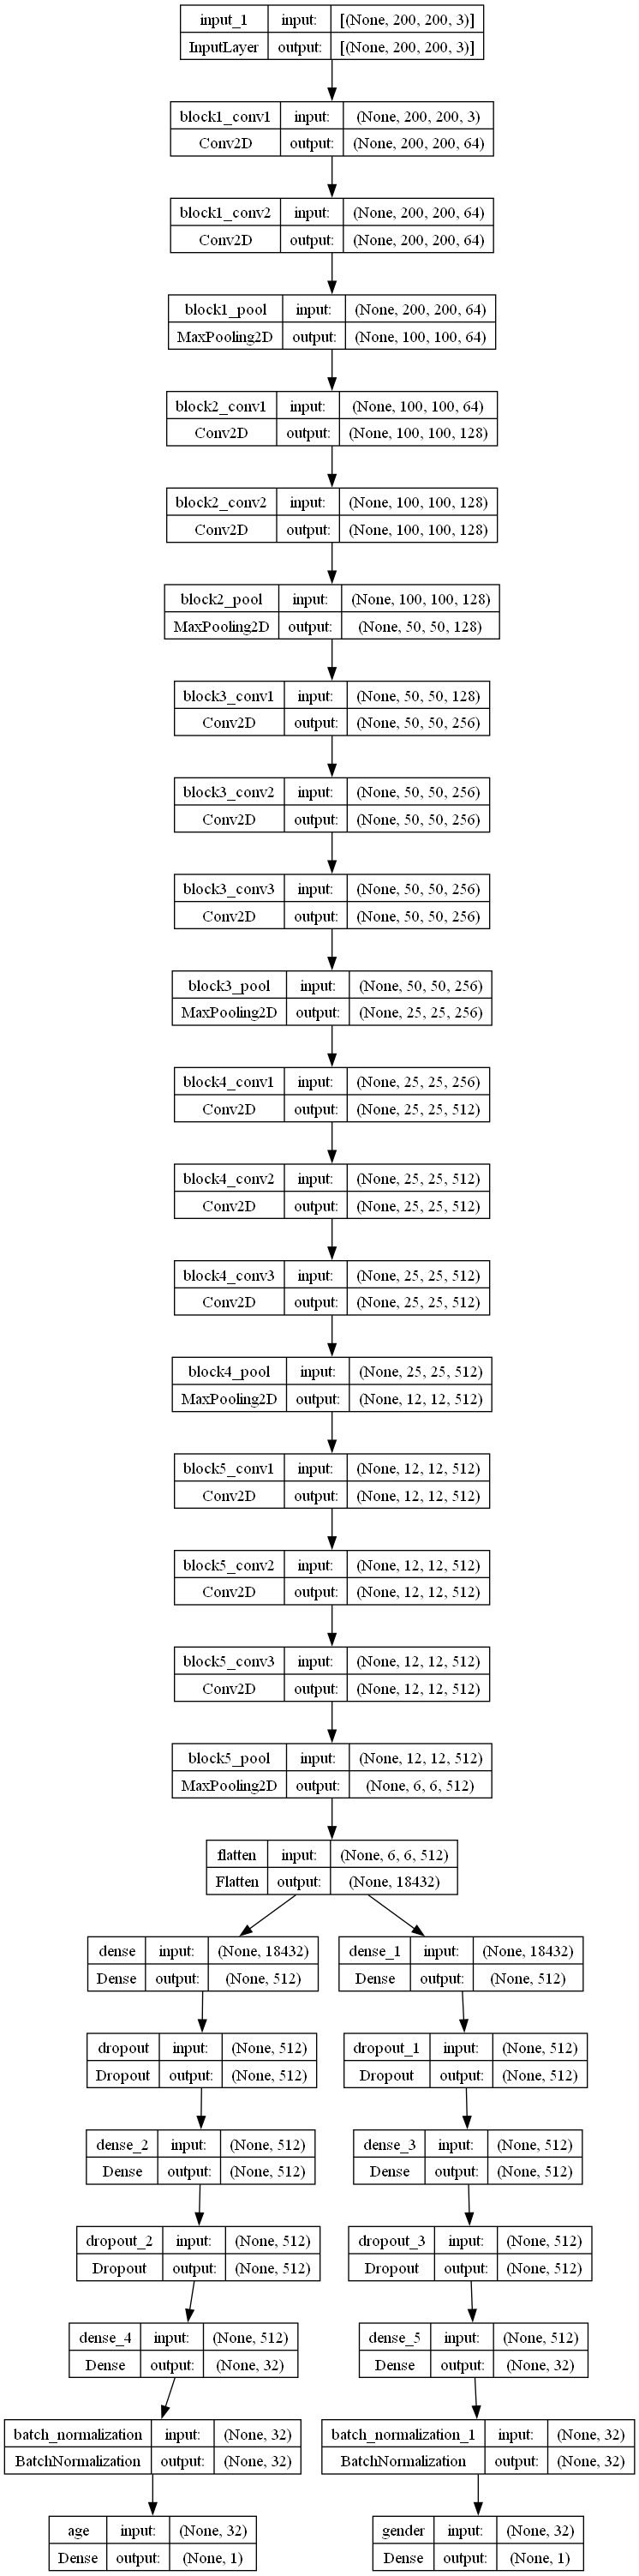

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)


# **Model Compilation and Training Process** 🚀

For training our model, we will compile it with the following configurations:

- **Batch Size:** 32
- **Epochs:** 200
- **Optimizer:** Adam
- **Age Loss:** Mean Absolute Error (MAE)
- **Gender Loss:** Binary Crossentropy

Now, let's proceed with compiling the model and initiating the training process.


In [ ]:
model.compile(optimizer='adam', loss={'age':'mae','gender':'binary_crossentropy'},metrics={'age':'mae','gender':'accuracy'})

In [ ]:
history = model.fit(train_generator, batch_size=32, epochs=200,validation_data= test_generator)

Epoch 1/200
625/625 [==============================] - 140s 220ms/step - loss: 21.3215 - age_loss: 20.7872 - gender_loss: 0.5343 - age_mae: 20.7872 - gender_accuracy: 0.7351 - val_loss: 13.7088 - val_age_loss: 13.2918 - val_gender_loss: 0.4170 - val_age_mae: 13.2918 - val_gender_accuracy: 0.8218
Epoch 2/200
625/625 [==============================] - 126s 201ms/step - loss: 11.7140 - age_loss: 11.2354 - gender_loss: 0.4786 - age_mae: 11.2354 - gender_accuracy: 0.7674 - val_loss: 10.6447 - val_age_loss: 10.2523 - val_gender_loss: 0.3925 - val_age_mae: 10.2523 - val_gender_accuracy: 0.8107
Epoch 3/200
625/625 [==============================] - 126s 201ms/step - loss: 10.4612 - age_loss: 10.0090 - gender_loss: 0.4522 - age_mae: 10.0090 - gender_accuracy: 0.7855 - val_loss: 19.7308 - val_age_loss: 19.4022 - val_gender_loss: 0.3286 - val_age_mae: 19.4022 - val_gender_accuracy: 0.8541
Epoch 4/200
625/625 [==============================] - 145s 232ms/step - loss: 10.2706 - age_loss: 9.8325 - g

# **Model Training Plots** 📊

In this section, we will visualize the training process of our model through plots of loss and accuracy.

## Loss Plots

We will display plots showing the trend of loss values over epochs for both age and gender prediction tasks.

## Accuracy Plots

Additionally, we will present plots illustrating the accuracy of our model's predictions over epochs for age and gender classification.

Let's generate and analyze these plots to gain insights into the performance and training dynamics of our model.


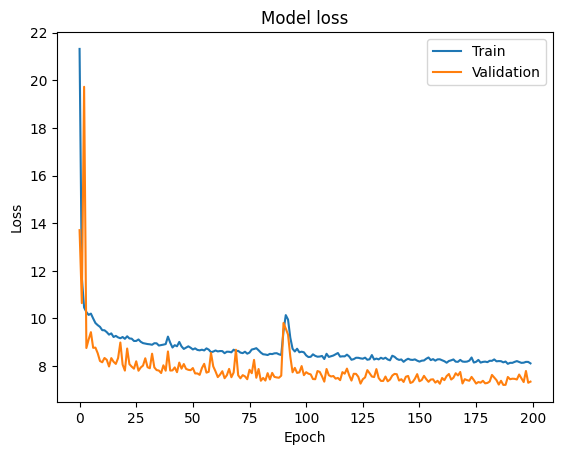

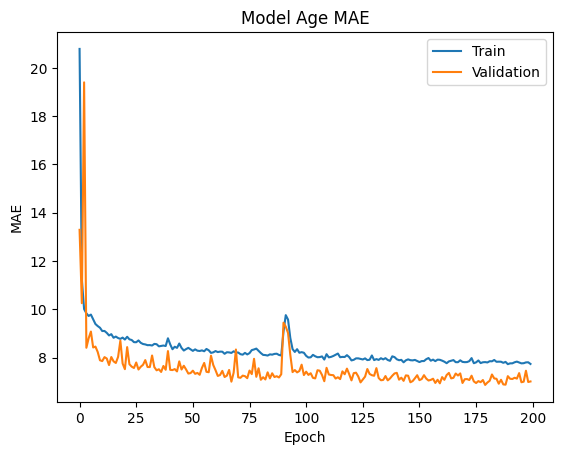

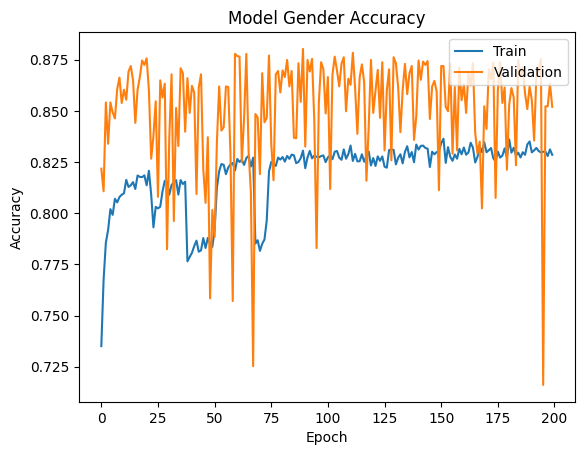

In [ ]:
# prompt: plot the all parameters of the epoch

import matplotlib.pyplot as plt

# Get the history object from the model's training
history = model.history

# Plot the loss and accuracy curves for both the training and validation sets
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['age_mae'])
plt.plot(history.history['val_age_mae'])
plt.title('Model Age MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['gender_accuracy'])
plt.plot(history.history['val_gender_accuracy'])
plt.title('Model Gender Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


# **Save the Model** 💾

Once our model is trained and has achieved satisfactory performance, we will save it for future use. Saving the model allows us to easily load it and make predictions without having to retrain it from scratch.


In [ ]:
model_path = 'OneDrive\\Desktop\\age and gender practiction\\age_gen_net_vgg4.h5'
model.save(model_path)

In [ ]:
model_path = 'OneDrive\\Desktop\\age and gender practiction\\age_gen_net_vgg4.h5'

In [ ]:
model = tf.keras.models.load_model(model_path)

# **Testing** 🧪

In this section, we will evaluate the performance of our trained model by testing it with new images and examining its predictions.


In [ ]:
img_path = 'Downloads\\ani.jpg'

In [ ]:
from numpy import round

In [ ]:
def show_image(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.show()
  img = cv2.resize(img,(200,200))
  img = img/255.0
  img = np.expand_dims(img,axis=0)
  pred = model.predict(img)
  print(pred[1][0])
  if pred[1][0] > 0.3:
    print('Predicted Gender:', 'female')
  else:
    print('Predicted Gender:', 'male')
  print('Predicted Age:', round(pred[0][0], 2))


In [ ]:
# prompt: modify the show_image code show that it should accuracy

def show_image(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.show()
  img = cv2.resize(img,(200,200))
  img = img/255.0
  img = np.expand_dims(img,axis=0)
  pred = model.predict(img)
  print(pred[1][0])
  if pred[1][0] > 0.3:
    print('Predicted Gender:', 'female')
  else:
    print('Predicted Gender:', 'male')
  print('Predicted Age:', round(pred[0][0], 2))
  print('Age Accuracy:', history.history['age_mae'][-1])
  print('Gender Accuracy:', history.history['gender_accuracy'][-1])



In [ ]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(200,200))
img = img/255.0
print(img)

[[[0.2        0.19607843 0.21568627]
  [0.27843137 0.2745098  0.29411765]
  [0.32156863 0.32156863 0.3372549 ]
  ...
  [0.21960784 0.16470588 0.11372549]
  [0.21176471 0.15686275 0.10588235]
  [0.24313725 0.18823529 0.1372549 ]]

 [[0.20392157 0.2        0.21960784]
  [0.24313725 0.23921569 0.25882353]
  [0.28627451 0.28235294 0.30196078]
  ...
  [0.21568627 0.16078431 0.10980392]
  [0.21176471 0.15686275 0.10588235]
  [0.25098039 0.19607843 0.14509804]]

 [[0.21176471 0.20784314 0.23137255]
  [0.20784314 0.20392157 0.22745098]
  [0.24313725 0.23921569 0.25882353]
  ...
  [0.20784314 0.15294118 0.10196078]
  [0.23529412 0.18039216 0.12941176]
  [0.29019608 0.23529412 0.18431373]]

 ...

 [[0.85098039 0.82745098 0.61568627]
  [0.76862745 0.74117647 0.54117647]
  [0.62745098 0.58823529 0.40392157]
  ...
  [0.4627451  0.54117647 0.25882353]
  [0.45098039 0.52941176 0.24705882]
  [0.45098039 0.52941176 0.24705882]]

 [[0.81568627 0.8        0.56078431]
  [0.72941176 0.70196078 0.48627451]


In [ ]:
type(img)

numpy.ndarray

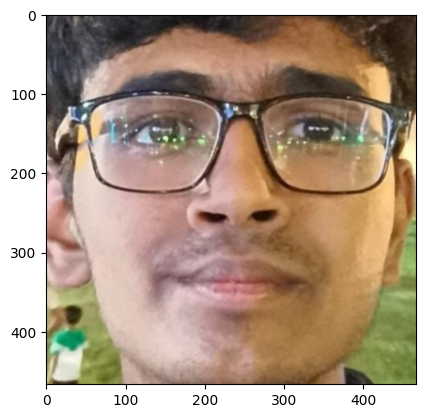

1/1 [==============================] - 0s 19ms/step
[0.14519863]
Predicted Gender: male
Predicted Age: [17.66]
Age Accuracy: 7.734795093536377
Gender Accuracy: 0.8285499811172485


In [ ]:
show_image(img_path)

In [ ]:
img_path = 'Downloads\\ronu.jpg'

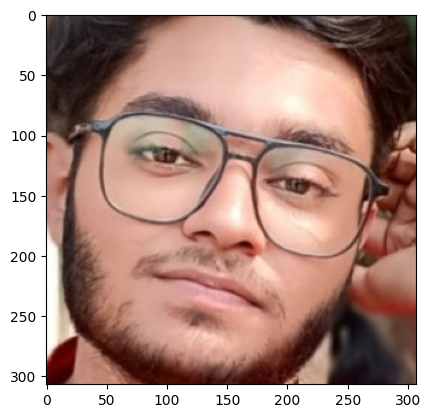

1/1 [==============================] - 0s 19ms/step
[0.02786787]
Predicted Gender: male
Predicted Age: [32.59]


In [ ]:
show_image(img_path)

In [ ]:
img_path = 'OneDrive\\Desktop\\age and gender practiction\\utkcropped\\14_1_4_20170109205457235.jpg.chip.jpg'

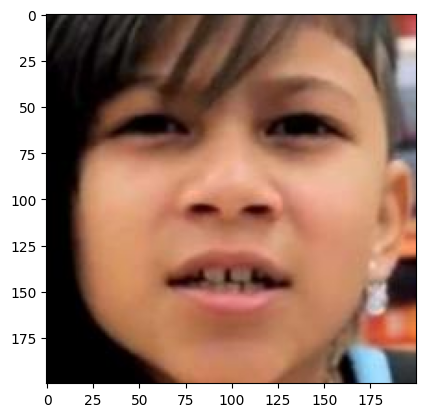

1/1 [==============================] - 0s 19ms/step
[0.1311166]
Predicted Gender: male
Predicted Age: [12.31]


In [ ]:
show_image(img_path)

In [ ]:
img_path = 'Downloads\\amitav.jpg'

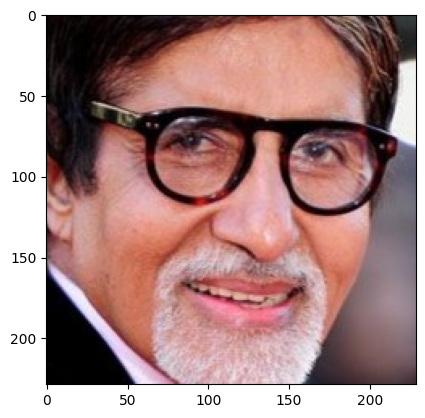

1/1 [==============================] - 0s 19ms/step
[0.37362704]
Predicted Gender: female
Predicted Age: [50.26]


In [ ]:
show_image(img_path)

400
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_0_20170110224751365.jpg.chip.jpg


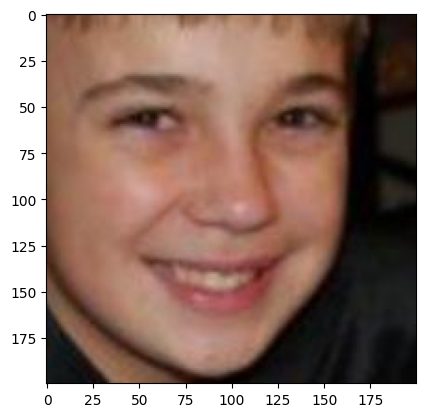

1/1 [==============================] - 0s 20ms/step
[0.74454427]
Predicted Gender: female
Predicted Age: [38.48]
401
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_0_20170110224801290.jpg.chip.jpg


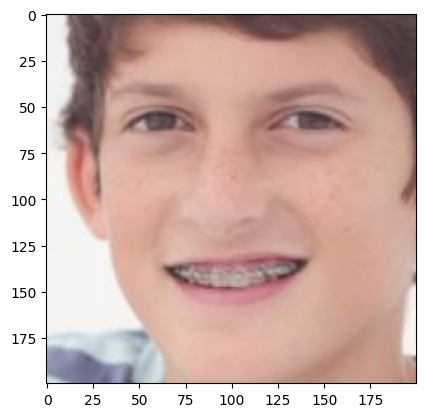

1/1 [==============================] - 0s 19ms/step
[0.09448752]
Predicted Gender: male
Predicted Age: [16.29]
402
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_0_20170110225045970.jpg.chip.jpg


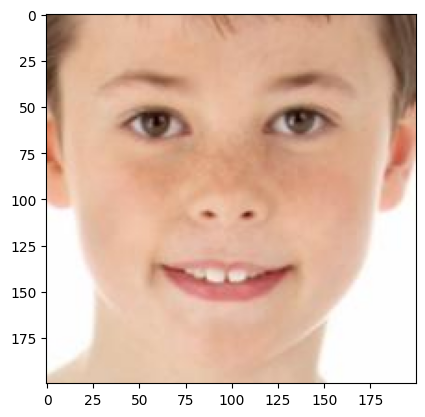

1/1 [==============================] - 0s 17ms/step
[0.4230801]
Predicted Gender: female
Predicted Age: [7.84]
403
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_0_20170110225059227.jpg.chip.jpg


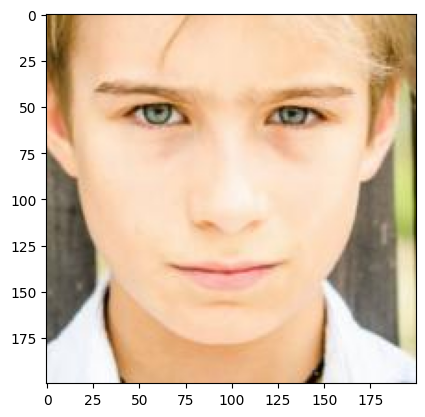

1/1 [==============================] - 0s 19ms/step
[0.1568492]
Predicted Gender: male
Predicted Age: [12.53]
404
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_0_20170110225302179.jpg.chip.jpg


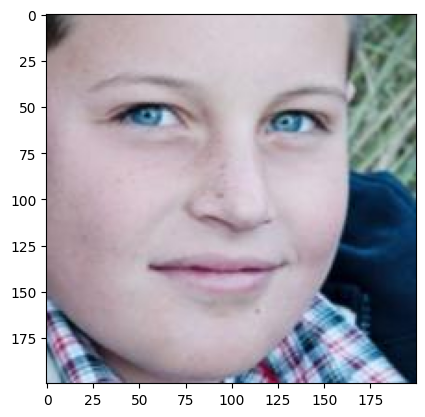

1/1 [==============================] - 0s 18ms/step
[0.680955]
Predicted Gender: female
Predicted Age: [14.28]
405
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_0_20170110225307195.jpg.chip.jpg


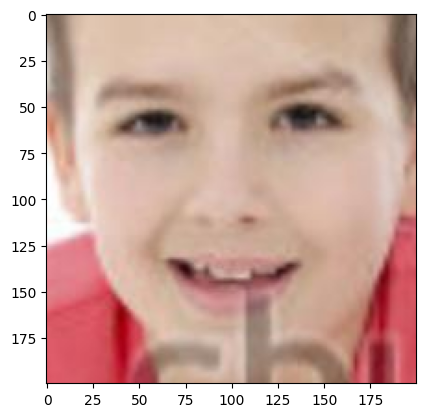

1/1 [==============================] - 0s 19ms/step
[0.6222985]
Predicted Gender: female
Predicted Age: [3.9]
406
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_0_20170110225428740.jpg.chip.jpg


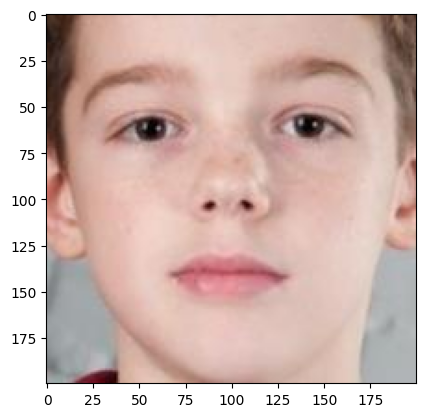

1/1 [==============================] - 0s 17ms/step
[0.18896325]
Predicted Gender: male
Predicted Age: [13.73]
407
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_0_20170110225438328.jpg.chip.jpg


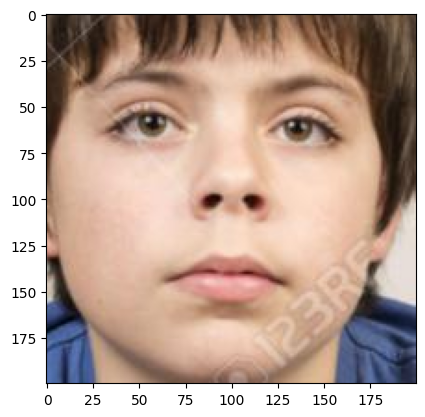

1/1 [==============================] - 0s 18ms/step
[0.06781458]
Predicted Gender: male
Predicted Age: [10.36]
408
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_0_20170110225447389.jpg.chip.jpg


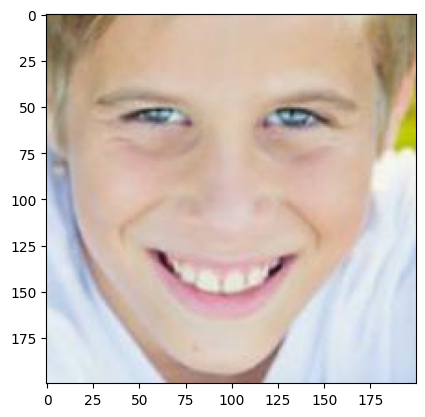

1/1 [==============================] - 0s 20ms/step
[0.65086585]
Predicted Gender: female
Predicted Age: [9.45]
409
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_0_20170110225513115.jpg.chip.jpg


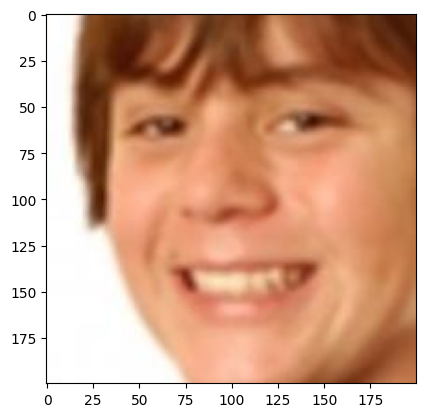

1/1 [==============================] - 0s 19ms/step
[0.12547973]
Predicted Gender: male
Predicted Age: [41.4]
410
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_0_20170110225717809.jpg.chip.jpg


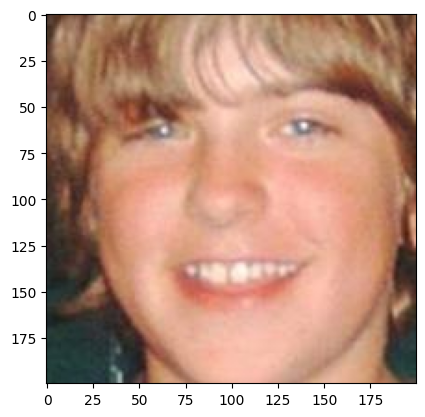

1/1 [==============================] - 0s 18ms/step
[0.12899624]
Predicted Gender: male
Predicted Age: [19.28]
411
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_0_20170110232519225.jpg.chip.jpg


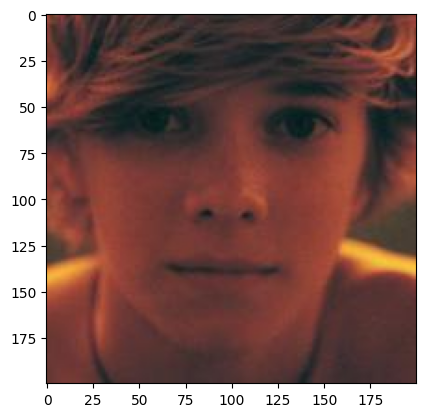

1/1 [==============================] - 0s 19ms/step
[0.04548083]
Predicted Gender: male
Predicted Age: [23.5]
412
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_0_20170110232526929.jpg.chip.jpg


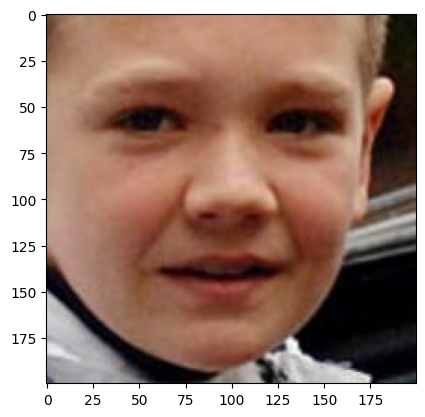

1/1 [==============================] - 0s 18ms/step
[0.142013]
Predicted Gender: male
Predicted Age: [0.]
413
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_1_20170110232537879.jpg.chip.jpg


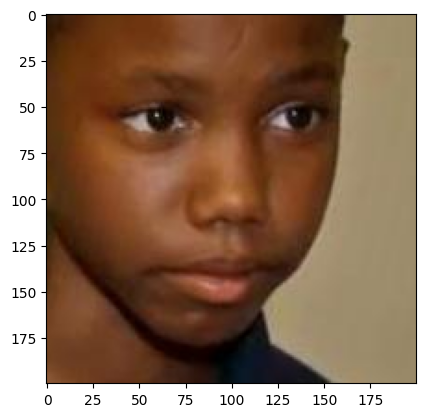

1/1 [==============================] - 0s 18ms/step
[0.15611342]
Predicted Gender: male
Predicted Age: [12.41]
414
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_1_20170113150907477.jpg.chip.jpg


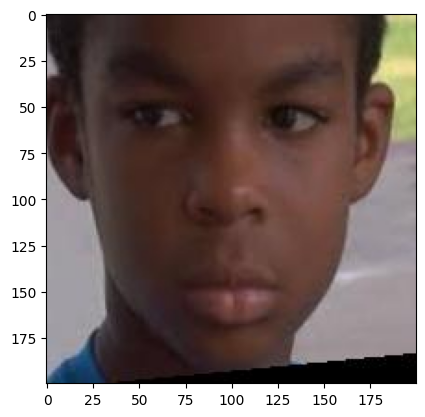

1/1 [==============================] - 0s 19ms/step
[0.01881956]
Predicted Gender: male
Predicted Age: [21.23]
415
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_2_20170103201143159.jpg.chip.jpg


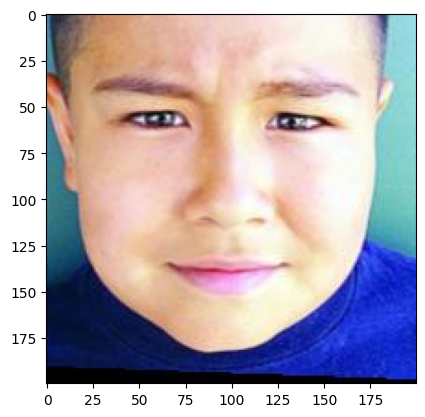

1/1 [==============================] - 0s 19ms/step
[0.06437681]
Predicted Gender: male
Predicted Age: [9.99]
416
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_2_20170103201417686.jpg.chip.jpg


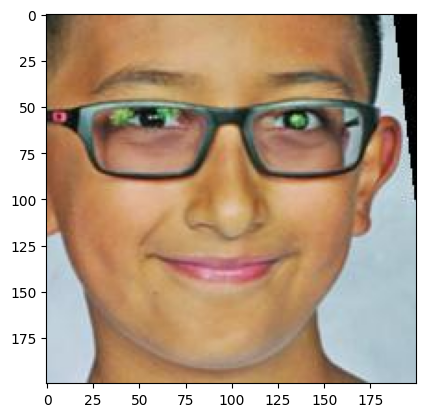

1/1 [==============================] - 0s 18ms/step
[0.24979974]
Predicted Gender: male
Predicted Age: [35.76]
417
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_2_20170117152653604.jpg.chip.jpg


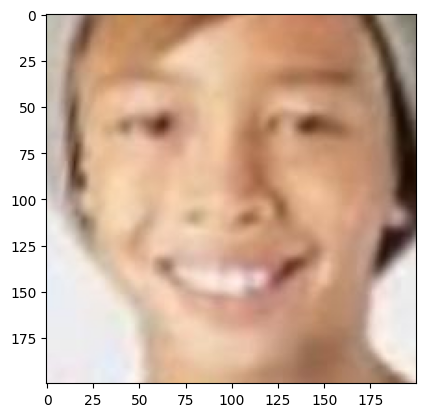

1/1 [==============================] - 0s 18ms/step
[0.24199903]
Predicted Gender: male
Predicted Age: [26.19]
418
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_3_20170110232628896.jpg.chip.jpg


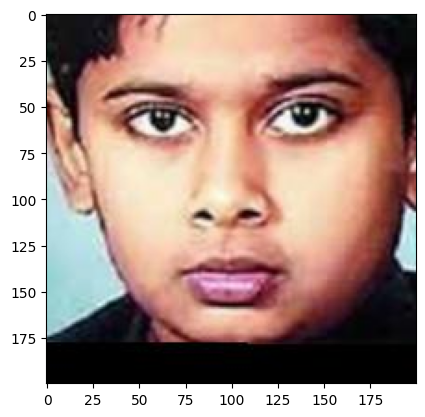

1/1 [==============================] - 0s 18ms/step
[0.2385107]
Predicted Gender: male
Predicted Age: [15.73]
419
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_3_20170119153840721.jpg.chip.jpg


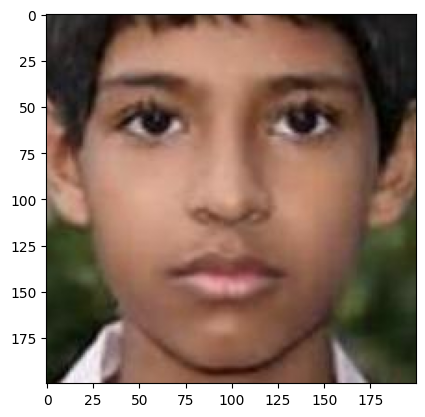

1/1 [==============================] - 0s 18ms/step
[0.10375164]
Predicted Gender: male
Predicted Age: [25.09]


In [ ]:
for i in range(400, 420):
  print(i)
  selected_image_index = i  # You can change this index to view other images
  selected_image_path = os.path.join(folder_path, df['image'][selected_image_index])
  print(selected_image_path)
  show_image(selected_image_path)

In [ ]:
selected_image_path


'OneDrive\\Desktop\\age and gender practiction\\utkcropped\\13_0_3_20170119153840721.jpg.chip.jpg'

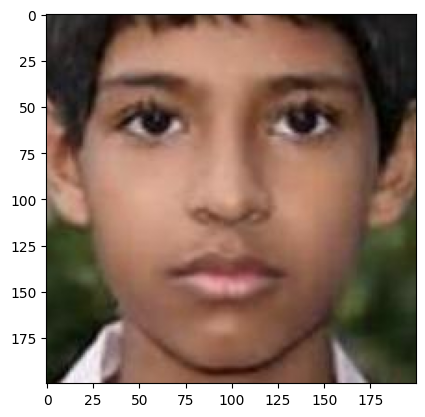

1/1 [==============================] - 0s 20ms/step
[0.10375164]
Predicted Gender: male
Predicted Age: [25.09]


In [ ]:
show_image(selected_image_path)

In [ ]:
import cv2
import numpy as np

# Load the pre-trained face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to detect faces and resize them to (200, 200)
def detect_faces(camera):
    while True:
        # Capture frame-by-frame
        ret, frame = camera.read()

        # Convert the frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces in the frame
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Iterate over each detected face
        for (x, y, w, h) in faces:
            # Extract the face region
            face_roi = frame[y:y+h, x:x+w]

            # Resize the face region to (200, 200)
            face_resized = cv2.resize(face_roi, (200, 200))

            # Return the face image as a NumPy array
            return face_resized

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the camera
    camera.release()
    cv2.destroyAllWindows()

# Open the default camera
camera = cv2.VideoCapture(0)

# Call the function to detect faces
face_image = detect_faces(camera)
face_image = face_image/255.0
print(face_image.shape)  # Print the shape of the returned face image
print(face_image)
# Release the camera
camera.release()


(200, 200, 3)
[[[0.04705882 0.04705882 0.04705882]
  [0.04705882 0.04705882 0.04705882]
  [0.04705882 0.04705882 0.04705882]
  ...
  [0.49411765 0.49411765 0.49411765]
  [0.49411765 0.49411765 0.49411765]
  [0.49019608 0.49019608 0.49019608]]

 [[0.04705882 0.04705882 0.04705882]
  [0.04705882 0.04705882 0.04705882]
  [0.04705882 0.04705882 0.04705882]
  ...
  [0.49411765 0.49411765 0.49411765]
  [0.49411765 0.49411765 0.49411765]
  [0.49019608 0.49019608 0.49019608]]

 [[0.04705882 0.04705882 0.04705882]
  [0.04705882 0.04705882 0.04705882]
  [0.05098039 0.05098039 0.05098039]
  ...
  [0.49411765 0.49411765 0.49411765]
  [0.49411765 0.49411765 0.49411765]
  [0.49019608 0.49019608 0.49019608]]

 ...

 [[0.52156863 0.60392157 0.6       ]
  [0.20784314 0.27058824 0.27058824]
  [0.08235294 0.12156863 0.12156863]
  ...
  [0.41176471 0.53333333 0.52941176]
  [0.40784314 0.53333333 0.52941176]
  [0.41176471 0.52941176 0.53333333]]

 [[0.43137255 0.50196078 0.50196078]
  [0.11764706 0.1686274

In [ ]:
face_image = np.expand_dims(face_image,axis=0)
pred = model.predict(face_image)
if pred[1][0] > 0.5:
  print('Predicted Gender:', 'female')
else:
  print('Predicted Gender:', 'male')
print('Predicted Age:', round(pred[0][0], 2))

1/1 [==============================] - 0s 20ms/step
Predicted Gender: male
Predicted Age: [21.35]


Build a camera program while take the input through the webcam and detect faces with the help of cv2

In [ ]:
import cv2
import numpy as np

# Load the pre-trained face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to detect faces and resize them to (200, 200)
def detect_faces(camera):
    while True:
        # Capture frame-by-frame
        ret, frame = camera.read()

        # Convert the frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces in the frame
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Iterate over each detected face
        for (x, y, w, h) in faces:
            # Draw a rectangle around the face
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

            # Extract the face region
            face_roi = frame[y:y+h, x:x+w]

            # Resize the face region to (200, 200)
            face_resized = cv2.resize(face_roi, (200, 200))
            face_resized = face_resized/255.0
            # Print the face image values
            face_resized = np.expand_dims(face_resized,axis=0)
            pred = model.predict(face_resized)
            print(pred[1][0])
            if pred[1][0] > 0.3:
              print('Predicted Gender:', 'female')
            else:
              print('Predicted Gender:', 'male')
            print('Predicted Age:', round(pred[0][0], 2))

        # Display the frame
        cv2.imshow('Frame', frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the camera
    camera.release()
    cv2.destroyAllWindows()

# Open the default camera
camera = cv2.VideoCapture(0)

# Call the function to detect faces
detect_faces(camera)
